# Predicting Dengue Fever Cases
#### Nicole Bohra & Ansul Sinha

In [1]:
#Set-up
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Load data
dengue_cases = pd.read_csv('prepped/OG_data_cases.csv', parse_dates=True)

In [3]:
# Here, we are setting the city equal to a numerical value. If the city is Iquitos, represented by "iq", the corresponding number is 1. If not, the city is San Juan, with a number of 0.
dengue_cases['city_num'] = np.where(dengue_cases['city'] == 'iq', "1", "0")
          

# Data Preperation: Adding Features

#### For our feature selection, we will be creating a high_rainfall column which indiciates whether a certain week of year had more than 50mm of precipitation. We add in this feature because we want to understand the different environmental factors, especially the differences in San Juan and Iquitos, that may relate to a higher number dengue cases.

In [4]:
# create high rainfall column
dengue_cases['high_rainfall'] = (dengue_cases['precipitation_amt_mm'] >= 50).astype(int)


Before deciding on the feature to add, we want to understand the relationship between the total number of cases and the city. The bar graph below plots the results.

<BarContainer object of 1456 artists>

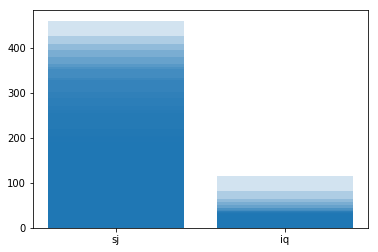

In [5]:
# What is the relationship between total cases and city?
plt.bar(dengue_cases.city, dengue_cases.total_cases, alpha=.2)

We also wanted to understand whether there was a relationship between the week of year and total number of dengue cases, which is displayed through the plot below.

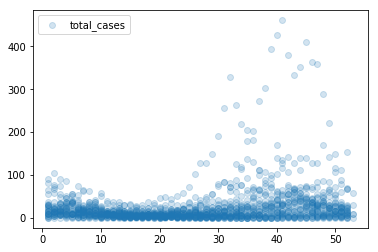

In [6]:
# What is the relationship between the week of year and total cases?
plt.scatter(dengue_cases.weekofyear, dengue_cases.total_cases, alpha=.2)
plt.legend()

Based on the data, we understand that San Juan has more cases than Iquitos. 
We now want to compare the different environmental elements between the two cities to understand why. This is why we chose rainfall, an environmental element, as our new feature. The bar graph shows whether there was high rainfall or not, and the corresponding number of dengue cases. It looks like there was a higher number of cases with lower rainfall. Interesting! 

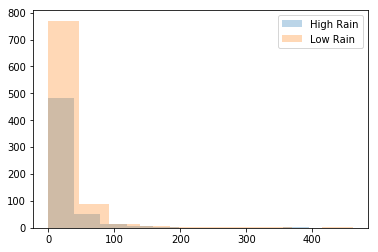

In [7]:
plt.figure()
plt.hist(dengue_cases.total_cases[dengue_cases.high_rainfall == True], label="High Rain", alpha = .3)
plt.hist(dengue_cases.total_cases[dengue_cases.high_rainfall == False], label="Low Rain", alpha = .3)
plt.legend()

Here is a table representation of the data with the city, whether there was high rainfall (represented by a 0) or low rainfall (represented by a 1), and the total number of dengue cases. This essentially backs up our observation with the bar chart above.

In [8]:
plt_df = dengue_cases.groupby(['high_rainfall', 'city'], as_index=False)[['total_cases']].sum()


In the following histogram distribution, we visualize that a higher number of cases are with low rain, and we see which city it corresponds to. We do this to understand whether this is a major player in determining dengue cases.

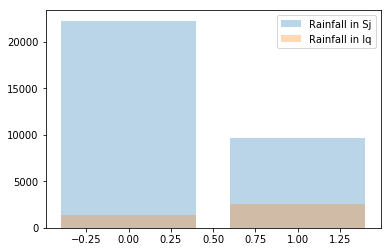

In [9]:
#Based on the histogram distribution, we can see that a higher number of cases are with low rain. 
#To understand whether this is because of the city, we will compare city and high rainfall
plt.figure()
plt.bar(plt_df.high_rainfall[plt_df.city=="sj"], plt_df.total_cases[plt_df.city=="sj"], label="Rainfall in Sj", alpha=.3)
plt.bar(plt_df.high_rainfall[plt_df.city=="iq"], plt_df.total_cases[plt_df.city=="iq"], label="Rainfall in Iq", alpha=.3)

plt.legend()

# Feature Selection: Select Best Features

### The first step was to load the data into a pandas dataframe; this would make it easier to wrangle data. We start by filling in "na" values, and dealing with any unused columns. We split our data into two sets: one dataframe with the outcome of total cases, and one with all the potential variables. To select the best features, we use Select Percentile and a Variance approach.

Here is our original dataframe with missing values added.

In [10]:
data_pd = pd.DataFrame(columns=dengue_cases.columns, data = dengue_cases.values)
data_pd['outcome'] = dengue_cases.total_cases
dengue_cases = dengue_cases.drop("city", axis=1)
dengue_cases = dengue_cases.drop("city.1", axis=1)
dengue_cases = dengue_cases.drop("week_start_date", axis=1)

dengue_cases = dengue_cases.fillna(0)
dengue_cases

,Unnamed: 0,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,year.1,weekofyear.1,total_cases,city_num,high_rainfall
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,-248.56,...,25.442857,6.900000,29.4,20.0,16.0,1990,18,4,0,0
1,2,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,-247.86,...,26.714286,6.371429,31.7,22.2,8.6,1990,19,5,0,0
2,3,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,-247.42,...,26.714286,6.485714,32.2,22.8,41.4,1990,20,4,0,0
3,4,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,-247.07,...,27.471429,6.771429,33.3,23.3,4.0,1990,21,3,0,0
4,5,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,-246.64,...,28.942857,9.371429,35.0,23.9,5.8,1990,22,6,0,0
5,6,1990,23,0.000000,0.174850,0.254314,0.181743,9.58,299.630000,-246.54,...,28.114286,6.942857,34.4,23.9,39.1,1990,23,2,0,0
6,7,1990,24,0.112900,0.092800,0.205071,0.210271,3.48,299.207143,-247.08,...,27.414286,6.771429,32.2,23.3,29.7,1990,24,4,0,0
7,8,1990,25,0.072500,0.072500,0.151471,0.133029,151.12,299.591429,-246.77,...,28.371429,7.685714,33.9,22.8,21.1,1990,25,5,0,1
8,9,1990,26,0.102450,0.146175,0.125571,0.123600,19.32,299.578571,-246.74,...,28.328571,7.385714,33.9,22.8,21.1,1990,26,10,0,0
9,10,1990,27,0.000000,0.121550,0.160683,0.202567,14.41,300.154286,-246.02,...,28.328571,6.514286,33.9,24.4,1.1,1990,27,6,0,0


In [11]:
dengue_cases_ans = dengue_cases["total_cases"]

dengue_cases_df = dengue_cases.drop("total_cases", axis=1)



Here is the grid score from our percentile selector using variance:

In [12]:
# Create a percentile selector, add it to the pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors = 3)
# Add a polynomial transformation to the pipeline
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Splitting of test/train data by 30%
train_features, test_features, train_outcome, test_outcome = train_test_split(dengue_cases_df, dengue_cases_ans ,test_size=0.3)

selecter = SelectPercentile()
threshold = VarianceThreshold(.1)
pipe = make_pipeline(poly, threshold, scaler, selecter, knn_reg)

# Define a grid to search through (including the degree of polynomial AND percentile of best features)
param_grid = {
              'polynomialfeatures__degree':range(1, 3),
              'selectpercentile__percentile':range(10, 30, 5),
              'kneighborsregressor__n_neighbors':range(1, 5), 
              'kneighborsregressor__weights':["uniform", "distance"]
}

grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

-15.874265892630106

# Algorithm 1: Decision Tree

#### The first algorithm we are using is a decision tree which solves the problem using tree representations. We decided to start with this algorithm because it can use to predict value of target variables by learning decision rules based on prior training data.

In [13]:
# Import your model, a decision tree classifier (typically imported at the beginning of your script)
from sklearn.tree import DecisionTreeRegressor

In [14]:
tree_reg = DecisionTreeRegressor(random_state=11)
tree_fit = tree_reg.fit(dengue_cases_df, dengue_cases_ans)


In [15]:
# Assess the fit of our data by generating predictions using your data
# Then calculate the accuracy (percentage of the time that the predictions equal the data)

tree_preds = tree_fit.predict(test_features)


In [16]:
dengue_without = dengue_cases_df
dengue_without = dengue_without.drop('Unnamed: 0', axis = 1)
dengue_without = dengue_without.drop('year.1', axis = 1)
dengue_without = dengue_without.drop('weekofyear.1', axis = 1)



In [17]:
# Split your data into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split 
train_features, test_features, train_outcome, test_outcome = train_test_split(dengue_without, dengue_cases_ans ,test_size=0.30)


In [18]:
# Fit the classifier -- from above -- using our (training) data 
tree_fit = tree_reg.fit(train_features, train_outcome)


In [19]:
# Assess the Mean Absolute Error of our model using our (test) data. 
from sklearn.metrics import mean_absolute_error

tree_preds = tree_fit.predict(test_features)
MAE = mean_absolute_error(tree_preds, test_outcome)

In [20]:
print("The mean absolute error is", MAE)

The mean absolute error is 15.237986270022883


In [21]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [22]:
# fit a linear model
lm = linear_model.LinearRegression()
model = lm.fit(train_features, train_outcome)
predictions = lm.predict(test_features)


This plot represents the true values and predictions from our first algorithm. 

Text(0, 0.5, 'Predictions')

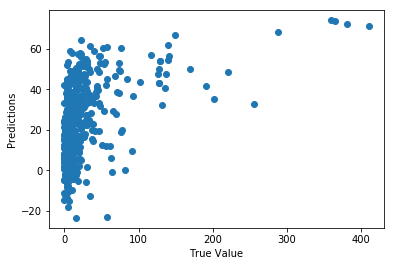

In [23]:
## The line / model
plt.scatter(test_outcome, predictions)
plt.xlabel("True Value")
plt.ylabel("Predictions")

The following value is our score for the model.. there was an attempt!

In [24]:
model.score(test_features, test_outcome)

0.2015712982521103

In [25]:
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=0)

In [26]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=train_features, y=train_outcome, cv=5)

Our accuracy scores mean is below:

In [27]:
all_accuracies.mean()

0.11030998395815939

In [28]:
test = cross_val_score(tree_reg, train_features, train_outcome )


In [29]:
#grid_search = GridSearchCV(DecisionTreeRegressor(), max_depth=20, random_state=99 )
#grid_search
params = {"max_depth": range(1,20), "random_state":[7]}


In [30]:
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid = params, cv = 5)


In [31]:
train_features = train_features.drop('high_rainfall', axis = 1)


Below: we fit the data into a grid search.

In [32]:
grid_search.fit(train_features, train_outcome)


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 20), 'random_state': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
test_features = test_features.drop("high_rainfall", axis = 1)


In [34]:
pred = grid_search.predict(test_features)


In [35]:
dengue_features_test = pd.read_csv('data/dengue_features_test.csv')

dengue_features_test['city_num'] = np.where(dengue_features_test['city'] == 'sj', "0", "1")

dengue_features_test = dengue_features_test.fillna(0)


dengue_features_test = dengue_features_test.drop('city', axis =1)
dengue_features_test = dengue_features_test.drop('week_start_date', axis = 1)
grid_search.predict(dengue_features_test)


array([ 10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  46.58333333,
        10.57532051,  46.58333333,  46.58333333,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57532051,
        10.57532051,  10.57532051,  10.57532051,  10.57

Our grid search score is below.

In [36]:
grid_search.score(test_features, test_outcome)


0.4810020760249416

In [37]:
dt_pred = grid_search.predict(dengue_features_test)


In [38]:
dengue_features_test['city'] = np.where(dengue_features_test['city_num'] == '0', "sj", "iq")

predictions = pd.DataFrame()
predictions['city'] = dengue_features_test['city']
predictions['year'] = dengue_features_test['year']
predictions['weekofyear'] = dengue_features_test['weekofyear']
predictions['total_cases'] = dt_pred.tolist()
predictions.total_cases = predictions.total_cases.astype(int)




In [39]:
predictions.total_cases = predictions.total_cases.astype(int)
submission = predictions

submission.to_csv("submission_DT.csv", index = False)


# Algorithm 2: KNN Regressor
#### Next, we used a KNN Regressor to observe how closely our features resemble our training set. We chose this regressor as it is a great algorithm in predicting continuous values of its k nearest neighbors.

In [40]:
# Import and create a KNN regressor that uses the 4 nearest points
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors = 3)

In [41]:
dengue_without2 = dengue_cases_df
dengue_without2 = dengue_without2.drop('Unnamed: 0', axis = 1)
dengue_without2 = dengue_without2.drop('year.1', axis = 1)
dengue_without2 = dengue_without2.drop('weekofyear.1', axis = 1)


In [42]:
# Create validation set by sampling 30% (.3) out of the *training* data
train_features, test_features, train_outcome, test_outcome = train_test_split(dengue_without2, dengue_cases_ans ,test_size=0.30)
               

In [43]:
# Fit the model to our (training) data, and use it to predict on our *test data*
knn_preds = knn_reg.fit(train_features, train_outcome).predict(test_features)

In [44]:
# Import the `GridSearchCV` model, and specify a grid of parameters
# This will try all possible combination of parameters in a brute force way
#And, it will run cross validation on each combination of parameters

from sklearn.model_selection import GridSearchCV
params = {"n_neighbors":range(1,50), "weights":["uniform", "distance"]}


For our second model, the mean of our cross validation score is below.

In [45]:
# Create a grid search estimator for your KNN classifier
# When fit, this will search the parameter grid using cross validation
# Use cross validation (`cross_val_score`) to test a classifier across 10 different splits of the data
# Use a K value of 3 for your KNN.
# Notice the huge variation in performance across folds!
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

knn_reg = KNeighborsRegressor(n_neighbors=3)
folds = KFold(n_splits = 10, shuffle = True)
np.mean(cross_val_score(knn_reg, train_features, train_outcome, cv = folds))




-0.17222596114429525

In [46]:
grid_search1 = GridSearchCV(KNeighborsRegressor(), param_grid = params, cv = folds)


In [47]:
train_features = train_features.drop('high_rainfall', axis =1)

In [48]:
# Fit the grid search to your training data
grid_search1.fit(train_features, train_outcome)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 50), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
test_features = test_features.drop('high_rainfall', axis =1)

Our predictions based on our first grid search follow:

In [50]:
grid_search1.predict(test_features)

array([17.57790279, 23.12938512, 17.44007305, 11.94342463, 15.01822864,
       22.75449023, 15.71970347, 21.27557364, 53.02913115, 19.80352905,
       19.46604556, 14.85665846, 12.59561596, 18.01003484, 21.48352983,
       34.59709739, 17.59147659, 10.50607721, 48.46233041, 49.33643064,
       51.69899919, 34.12350313, 20.51720841, 32.98752181, 33.61315109,
       19.19364969, 24.01575864, 21.8258982 , 16.52354877, 33.31665131,
       24.5630165 , 18.70808016, 37.02630795, 21.66401176, 31.69601456,
       36.77684356, 37.28655781, 23.62339339, 33.14615147, 48.53189164,
       16.9660326 , 14.89908379, 21.79925581, 14.47437663, 25.5918449 ,
       14.04216231, 22.7495155 , 14.75533773, 23.3516388 , 22.73671515,
       22.54575997, 23.54378319, 13.11650056, 19.95341555,  9.67627118,
       35.31393267, 22.51835219, 21.23820819, 32.66873883,  9.5837876 ,
       12.58063139, 30.13204195, 30.16258841, 15.22990451, 42.66600338,
       18.15638383, 32.16836297, 17.06131737, 43.06157098, 43.06

In [51]:
dengue_features_test_knn = pd.read_csv('data/dengue_features_test.csv', parse_dates=True)

dengue_features_test_knn['city_num'] = np.where(dengue_features_test_knn['city'] == 'sj', "0", "1")

dengue_features_test_knn = dengue_features_test_knn.fillna(0)


dengue_features_test_knn = dengue_features_test_knn.drop('city', axis =1)
dengue_features_test_knn = dengue_features_test_knn.drop('week_start_date', axis = 1)



The next number represents the grid search score for our predictions for our second model.

In [52]:
# Predict and assess performance on your **test** data
score = grid_search1.score(test_features, test_outcome)
print("The grid search score, which is the performance of our test data, is:", score)

The grid search score, which is the performance of our test data, is: 0.10821133268929062


In [53]:
knn_pred = grid_search1.predict(dengue_features_test_knn)

The plot is a visualization of performance across neighbors N values.

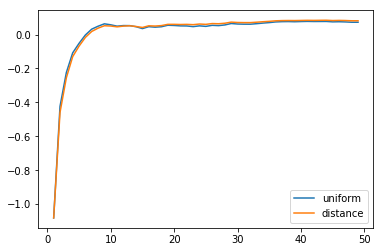

In [54]:
# Visualze performance across neighbors N values
grid_search.cv_results_['mean_test_score']

uniform_results = grid_search1.cv_results_['mean_test_score'][grid_search1.cv_results_['param_weights'].data == "uniform"]
distance_results = grid_search1.cv_results_['mean_test_score'][grid_search1.cv_results_['param_weights'].data == "distance"]
plt.plot(range(1,50), uniform_results, label="uniform")
plt.plot(range(1,50), distance_results, label="distance")
plt.legend()

In [55]:
# Import pipeline, and define your pipeline that will
# - Transform you data using a MinMaxScaler
# - Fit a KNN classifier
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(MinMaxScaler(), KNeighborsRegressor())

In [56]:
# Pass your pipeline to a grid search, specifying a set of neighbors to assess
# Split data into training and testing data
params = {"kneighborsregressor__n_neighbors":range(1,50), "kneighborsregressor__weights":["uniform", "distance"]}
grid_search = GridSearchCV(pipe, params, cv=5)

In [57]:
print("Here is our grid search fit for KNN Regressor: ")
grid_search.fit(train_features, train_outcome)

Here is our grid search fit for KNN Regressor: 


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kneighborsregressor__n_neighbors': range(1, 50), 'kneighborsregressor__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
print("Here is our grid search score for algorithm 2: ")
grid_search1.score(test_features, test_outcome)

Here is our grid search score for algorithm 2: 


0.10821133268929062

In [59]:
dengue_features_test_knn['city'] = np.where(dengue_features_test_knn['city_num'] == '0', "sj", "iq")

predictions_knn = pd.DataFrame()
predictions_knn['city'] = dengue_features_test['city']
predictions_knn['year'] = dengue_features_test['year']
predictions_knn['weekofyear'] = dengue_features_test['weekofyear']
predictions_knn['total_cases'] = knn_pred.tolist()
predictions_knn.total_cases = predictions.total_cases.astype(int)


In [60]:
predictions_knn.total_cases = predictions_knn.total_cases.astype(int)
submission2 = predictions_knn

submission2.to_csv("submission_KN.csv", index = False)


# Algorithm 3: Random Forest

### The third algorithm we chose is Random Forest, which is a collection of decision trees. After predicting using decision trees, we wanted to account for decision trees’ tendency to overfit the data to their training set. This algorithm constructs a multitude of decision trees and returns the mean regression.

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Define a pipeline that uses scaler and classifier

pipe = make_pipeline(MinMaxScaler(), RandomForestRegressor())

# Define a grid to search through
param_grid = {'RandomForestRegressor__n_neighbors':range(1, 30)}

# Perform a grid search of pipeline
grid = GridSearchCV(pipe, param_grid) 



In [62]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_outcome);



In [63]:
##test_features = test_features.drop("level_0", axis=1)
#test_features = test_features.drop("index", axis=1)
#test_features

# Use the forest's predict method on the test data

predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_outcome)

print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 11.69


This plot represents errors versus predictions. 

Text(0, 0.5, 'Predictions')

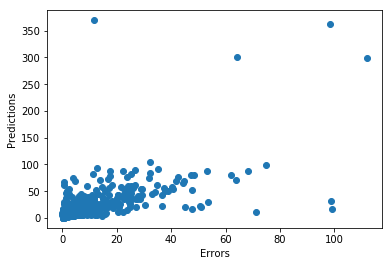

In [64]:
# Plot Errors vs Predictions
plt.scatter(errors, predictions)
plt.xlabel("Errors")
plt.ylabel("Predictions")


In [65]:
from sklearn import metrics

print('Mean absolute error:' ,  metrics.mean_absolute_error(predictions, errors))

Mean absolute error: 15.773281464530893


In [66]:
dengue_without1 = dengue_cases_df
dengue_without1 = dengue_without1.drop('Unnamed: 0', axis = 1)
dengue_without1 = dengue_without1.drop('year.1', axis = 1)
dengue_without1 = dengue_without1.drop('weekofyear.1', axis = 1)
dengue_without1 = dengue_without1.drop('high_rainfall', axis =1)


In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dengue_without1, dengue_cases_ans, test_size=0.30, random_state=0)

In [68]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [69]:
# Fit regressor on train data
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)



In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("Classification Report:",classification_report(y_test,y_pred.round()))
print("Accuracy Score:", accuracy_score(y_test, y_pred.round()))

Classification Report:              precision    recall  f1-score   support

        0.0       1.00      0.10      0.19        29
        1.0       0.00      0.00      0.00        20
        2.0       0.00      0.00      0.00        23
        3.0       0.20      0.15      0.17        20
        4.0       0.08      0.11      0.09        19
        5.0       0.00      0.00      0.00        22
        6.0       0.17      0.15      0.16        27
        7.0       0.04      0.07      0.05        15
        8.0       0.05      0.07      0.06        15
        9.0       0.08      0.08      0.08        12
       10.0       0.05      0.08      0.06        12
       11.0       0.06      0.06      0.06        16
       12.0       0.06      0.14      0.09         7
       13.0       0.00      0.00      0.00         8
       14.0       0.00      0.00      0.00         6
       15.0       0.00      0.00      0.00         6
       16.0       0.00      0.00      0.00         9
       17.0       0.14

In [71]:
from sklearn.ensemble import RandomForestRegressor  
Regressor = RandomForestRegressor(n_estimators=300, random_state=0)

In [72]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=Regressor, X=X_train, y=y_train, cv=5)

In [73]:
print("All accuracies mean:", all_accuracies.mean())

All accuracies mean: 0.6469438925022767


In [74]:
dengue_features_test2 = pd.read_csv('data/dengue_features_test.csv')

dengue_features_test2['city_num'] = np.where(dengue_features_test2['city'] == 'sj', "0", "1")

dengue_features_test2 = dengue_features_test2.fillna(0)


dengue_features_test2 = dengue_features_test2.drop('city', axis =1)
dengue_features_test2 = dengue_features_test2.drop('week_start_date', axis = 1)



In [75]:
rf_preds = pd.DataFrame(predictions)
rf_preds = rf_preds.reset_index()
test_features = test_features.reset_index()
rf_pred_cases = pd.concat([test_features, rf_preds], axis=1)


In [76]:
rf_pred_cases['city'] = np.where(rf_pred_cases['city_num'] == '0', "sj", "iq")
rf_pred_cases = rf_pred_cases.rename(columns={0: 'total_cases'})

city = rf_pred_cases['city']
year = rf_pred_cases['year']
weekofyear = rf_pred_cases['weekofyear']
rf_pred_cases.total_cases = rf_pred_cases.total_cases.astype(int)
total_cases = rf_pred_cases['total_cases']

submission3 = pd.concat([city, year, weekofyear, total_cases], axis=1)
submission3 = submission3.sort_values(by='year') 
submission3.reset_index
submission3.to_csv("submission3.csv", index = False)


# Algorithm 4: Bagging Regressor

In [77]:
from sklearn.ensemble import BaggingRegressor

In [78]:
# Define a pipeline that uses scaler and classifier

pipe = make_pipeline(MinMaxScaler(), BaggingRegressor())

# Define a grid to search through
param_grid = {'BaggingRegressor__n_neighbors':range(1, 30)}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid) 



In [79]:
# Instantiate model with 1000 decision trees
br = BaggingRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
br.fit(train_features, train_outcome);



In [80]:
# Use the forest's predict method on the test data
predictions = br.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_outcome)
# Print out the mean absolute error (MAE)
print('Mean Absolute Error (based on predictions - errors from forests predict method):', round(np.mean(errors), 2))

Mean Absolute Error (based on predictions - errors from forests predict method): 104.41


Text(0, 0.5, 'Predictions')

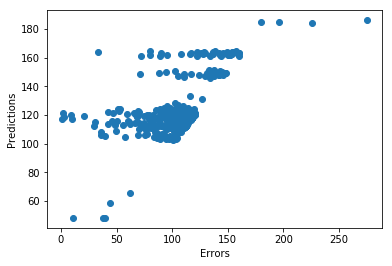

In [81]:
# Plot Errors vs Predictions
plt.scatter(errors, predictions)
plt.xlabel("Errors")
plt.ylabel("Predictions")

In [82]:
from sklearn import metrics

print('Mean absolute error based on metrics from sklearn:' ,  metrics.mean_absolute_error(predictions, errors))

Mean absolute error based on metrics from sklearn: 19.293638443935926


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dengue_cases_df, dengue_cases_ans, test_size=0.30, random_state=0)

In [84]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [85]:
regressor = BaggingRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)



In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("Classification Report:", classification_report(y_test,y_pred.round()))
print("Accuracy Score:",accuracy_score(y_test, y_pred.round()))

Classification Report:              precision    recall  f1-score   support

        0.0       0.83      0.17      0.29        29
        1.0       0.00      0.00      0.00        20
        2.0       0.00      0.00      0.00        23
        3.0       0.25      0.15      0.19        20
        4.0       0.11      0.11      0.11        19
        5.0       0.00      0.00      0.00        22
        6.0       0.13      0.11      0.12        27
        7.0       0.05      0.07      0.06        15
        8.0       0.05      0.07      0.05        15
        9.0       0.16      0.25      0.19        12
       10.0       0.06      0.08      0.07        12
       11.0       0.19      0.19      0.19        16
       12.0       0.00      0.00      0.00         7
       13.0       0.09      0.12      0.11         8
       14.0       0.00      0.00      0.00         6
       15.0       0.00      0.00      0.00         6
       16.0       0.07      0.11      0.08         9
       17.0       0.00

In [87]:
from sklearn.ensemble import BaggingRegressor
Regressor = BaggingRegressor(n_estimators=300, random_state=0)

In [88]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=Regressor, X=X_train, y=y_train, cv=5)

In [89]:
print("All accuracy scores mean:", all_accuracies.mean())

All accuracy scores mean: 0.6844203156860644


In [90]:
br_preds = pd.DataFrame(predictions)
br_preds = br_preds.reset_index()

br_pred_cases = pd.concat([test_features, br_preds], axis=1)

br_pred_cases = br_pred_cases.rename(columns={0: 'total_cases'})

br_pred_cases['city'] = np.where(br_pred_cases['city_num'] == '0', "sj", "iq")


In [91]:
city = br_pred_cases['city']
year = br_pred_cases['year']
weekofyear = br_pred_cases['weekofyear']
total_cases = br_pred_cases['total_cases']

submission4 = pd.concat([city, year, weekofyear, total_cases], axis=1)
submission4 = submission4.sort_values(by='year') 

submission4.to_csv("submission4.csv", index = False)


# Conclusion

### In conclusion, we found that our models may not be perfect (seen through the cross validation accuracy scores). We turned in two submissions: submission_DT and submission_KN; DT was decision tree, which received a score of 29, and was our best score. submission_KN received a score of 35. We did place 1603/5000+ competitors overall! Not too shabby, but we'll do better next time. Thanks for reading!